# **NLP Classification Assignment: Toxicity Detection**

## **Assignment Context**
This assignment is a **practical introduction to NLP and Machine Learning Classification**.  
The goal is to build and evaluate models that distinguish between **toxic** and **non-toxic** social media content.  

This task is highly relevant for:
- Platform moderation  
- Content filtering  
- Maintaining healthy online communities  

---

## **Workflow (Data Science Pipeline)**

1. **Data Loading & Cleaning**  
   - Preparing raw text for machine learning.  

2. **Exploratory Data Analysis (EDA)**  
   - Understanding distributions and biases (e.g., class imbalance).  

3. **Feature Engineering**  
   - Converting text into numerical features (vectorization).  

4. **Model Training & Evaluation**  
   - Comparing multiple algorithms using relevant metrics.  

---

## **Dataset Overview: `twitter.csv`**

| Column Name | Description |
|-------------|-------------|
| **id**      | A unique identifier for the tweet |
| **label**   | Target variable: `0 = Non-Toxic`, `1 = Toxic/Hate Speech` |
| **tweet**   | The raw text content of the tweet |

### **Key Characteristic: Class Imbalance**
- Majority class = `0 (Non-Toxic)`  
- Minority class = `1 (Toxic)`  
- Because of this imbalance, **Accuracy is unreliable** ‚Üí must use **F1-Score** for evaluation.

---

## **Assignment Objectives**

- **Robust Preprocessing**  
  - Noise removal (mentions, links)  
  - Stemming, lemmatization, stopword removal  

- **Feature Representation**  
  - Convert cleaned text ‚Üí numerical features using **Count Vectorizer (BoW - Bag of Words)**  
  - (Optional: TF-IDF for future exploration)  

- **Comparative Modeling**  
  - Train at least 3 models:  
    - Logistic Regression  
    - Multinomial Naive Bayes  
    - Gaussian Naive Bayes  

- **Critical Evaluation**  
  - Select the **best model based on F1-Score** for label = 1 (Toxic)  
  - Understand **why F1 is crucial for imbalanced data**  

---

## **Key Concepts and Techniques**

### **Natural Language Processing (NLP)**
- **Tokenization**: Split text into words/tokens  
- **Stopword Removal**: Remove common words like "the", "is", "a"  
- **Stemming**: Reduce words to their root (e.g., *running ‚Üí run*)  
- **Lemmatization**: Reduce words to dictionary form (e.g., *better ‚Üí good*)  

### **Feature Engineering**
- **Bag-of-Words (BoW)**: Represent text as unordered word counts  
- **Count Vectorizer**: Implements BoW (word frequency counts)  
- **TF-IDF**: Weighs words by frequency in document vs across all documents  

### **Machine Learning Models**
- **Logistic Regression**: Linear binary classifier (probabilistic)  
- **Naive Bayes (Multinomial & Gaussian)**: Probabilistic classifiers based on Bayes‚Äô Theorem, fast & effective for text  

---

## **Model Evaluation Metrics**

- **Confusion Matrix**  
  - Summarizes predictions:  
    - TP (True Positive)  
    - TN (True Negative)  
    - FP (False Positive)  
    - FN (False Negative)  

- **F1-Score**  
  - Harmonic mean of **Precision** and **Recall**  
  - Best for **imbalanced data**  

- **Precision (PPV)**  
  - Out of predicted Toxic tweets, how many are correct?  
  - Formula: $Precision = \frac{TP}{TP+FP}$  

- **Recall (Sensitivity)**  
  - Out of all actual Toxic tweets, how many did the model catch?  
  - Formula: $Recall = \frac{TP}{TP+FN}$  

# **Initial Setup**

In [ ]:
!pip install ipython-autotime

In [ ]:
#
# Magic command to get the elpased time for each cell
#
%load_ext autotime

In [77]:
#
# Import Libraries
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter                                               # Added for Word Frequency Analysis

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split                          # To split data into training and testing sets
from sklearn.feature_extraction.text import CountVectorizer                   # To get a frequency count of each word in a provided text
from sklearn.feature_extraction.text import TfidfVectorizer                   # To convert text into numerical features
from sklearn.linear_model import LogisticRegression                           # The Logistic Regression classifier model
from sklearn.naive_bayes import MultinomialNB, GaussianNB                     # The Naive Bayes classifier models
from sklearn.metrics import (
                              #
                              # Import all necessary metrics
                              #
                              classification_report,
                              confusion_matrix,
                              f1_score,
                              accuracy_score,
                              precision_score,
                              recall_score
                            )

from google.colab import files

#
# Suppress the UserWarning
#
import warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

time: 2.05 ms (started: 2025-09-30 15:53:10 +00:00)


In [78]:
#
# Ensure NLTK downloads are complete by catching LookupError
#
try:
  nltk.data.find('corpora/stopwords')
except LookupError:
  print("Downloading NLTK stopwords...")
  nltk.download('stopwords')

try:
  nltk.data.find('corpora/wordnet')
except LookupError:
  print("Downloading NLTK wordnet...")
  nltk.download('wordnet')

time: 100 ms (started: 2025-09-30 15:53:17 +00:00)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [79]:
#
# Set Pandas display format for floats
#
pd.options.display.float_format = '{:.2f}'.format

#
# Set NumPy's print options to suppress scientific notation and set precision.
#   'suppress  = True' - Prevents the use of scientific notation.
#   'precision = 2'    - Sets the number of decimal places to display.
#
np.set_printoptions(suppress = True, precision = 2)

time: 1.24 ms (started: 2025-09-30 15:53:21 +00:00)


In [80]:
#
# Set plotting style for better visualization aesthetics
#
sns.set_style('whitegrid')

time: 1.44 ms (started: 2025-09-30 15:53:24 +00:00)


In [81]:
#
# Upload the dataset 'twitter.csv'
#
uploadOutput = files.upload()

time: 2.49 s (started: 2025-09-30 15:53:30 +00:00)


# **Load Data**

In [82]:
datasetFileName = 'twitter.csv'
try:
  # IMPORTANT: This script relies on the uploaded 'twitter.csv' file.
  df = pd.read_csv(datasetFileName)
except FileNotFoundError:
  print("Error: '{}' not found. Exiting.".format(datasetFileName))
  exit()

time: 74.7 ms (started: 2025-09-30 15:53:33 +00:00)


In [83]:
print(df.shape)
print(df.size)

(31962, 3)
95886
time: 957 ¬µs (started: 2025-09-30 15:53:33 +00:00)


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
time: 16.3 ms (started: 2025-09-30 15:53:33 +00:00)


# **Statistical Analysis**

In [85]:
df.describe()

id    label
count 31962.00 31962.00
mean  15981.50     0.07
std    9226.78     0.26
min       1.00     0.00
25%    7991.25     0.00
50%   15981.50     0.00
75%   23971.75     0.00
max   31962.00     1.00

time: 17.5 ms (started: 2025-09-30 15:53:33 +00:00)


In [86]:
df.describe().T

count     mean     std  min     25%      50%      75%      max
id    31962.00 15981.50 9226.78 1.00 7991.25 15981.50 23971.75 31962.00
label 31962.00     0.07    0.26 0.00    0.00     0.00     0.00     1.00

time: 26.2 ms (started: 2025-09-30 15:53:33 +00:00)


In [87]:
df.describe(include = 'all')

id    label                                              tweet
count  31962.00 31962.00                                              31962
unique      NaN      NaN                                              29530
top         NaN      NaN  #model   i love u take with u all the time in ...
freq        NaN      NaN                                                319
mean   15981.50     0.07                                                NaN
std     9226.78     0.26                                                NaN
min        1.00     0.00                                                NaN
25%     7991.25     0.00                                                NaN
50%    15981.50     0.00                                                NaN
75%    23971.75     0.00                                                NaN
max    31962.00     1.00                                                NaN

time: 45.7 ms (started: 2025-09-30 15:53:33 +00:00)


# **Simple Pre-Processing**

## **Check Missing Values**

In [88]:
#
# Find only columns that has missing value
#

# df.isnull().sum().sort_values(ascending = False)
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)

Series([], dtype: int64)

time: 13.8 ms (started: 2025-09-30 15:53:33 +00:00)


In [89]:
#
# Get the rows that has missing values
#
missing_value_rows = df[df.isnull().any(axis = 1)]
print(missing_value_rows) # Commented out, if print as the output is large

Empty DataFrame
Columns: [id, label, tweet]
Index: []
time: 6.73 ms (started: 2025-09-30 15:53:33 +00:00)


In [90]:
#
# Percentage of missing values
#
missingValueRows = df.isnull().sum()
percentMissing   = ((df.isnull().sum() / df.shape[0]) * 100)

missingValueRows = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)
percentMissing   = ((df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False) / df.shape[0]) * 100)

# print("Missig Values")
# print("=============")
# print(missingValueRows)

# print("")

# print("Percent Missing")
# print("===============")
# print(percentMissing)

missingData = {
                'Missing Value Rows': missingValueRows,
                'Missing Percentage': percentMissing
              }
missingDataFrame = pd.DataFrame(missingData)
missingDataFrame

Empty DataFrame
Columns: [Missing Value Rows, Missing Percentage]
Index: []

time: 37 ms (started: 2025-09-30 15:53:33 +00:00)


## **Check Duplicates**

In [91]:
#
# Get Duplicate Count
#
df.duplicated().sum()

np.int64(0)

time: 30.2 ms (started: 2025-09-30 15:53:33 +00:00)


In [92]:
#
# Get Duplicate Row
#
duplicatedRows = df[df.duplicated()]
print(duplicatedRows)

Empty DataFrame
Columns: [id, label, tweet]
Index: []
time: 19.8 ms (started: 2025-09-30 15:53:33 +00:00)


# **Data Cleanse / Pre-Processing**

In [93]:
#
# Initialize the Lemmatizer and Stemmer
#
# NOTE: We use Lemmatization only in the current pipeline as it is generally
#       preferred for accuracy (reduces to dictionary words)
#
lemmatizer = WordNetLemmatizer() # Initializing the WordNetLemmatizer
stemmer    = PorterStemmer()     # Initializing the PorterStemmer

time: 1.22 ms (started: 2025-09-30 15:53:33 +00:00)


In [94]:
stopWords = set(stopwords.words('english'))

time: 1.68 ms (started: 2025-09-30 15:53:33 +00:00)


In [95]:
#
# Function to cleanse the text column
#
def cleanTweet(text):
  #
  # Performs a multi-step cleaning process on raw tweet text.
  #
  # Steps include:
  #   1. Removing Twitter user mentions (@...) and URLs (http/https).
  #   2. Removing special characters and isolated punctuation.
  #   3. Lowercasing, tokenizing, and filtering out common stopwords.
  #   4. Filtering out single-character tokens (e.g., 'a', 'i', or noise artifacts).
  #   5. Re-joining the final list of clean words into a single string.
  #

  #
  # Remove @mentions and URLs
  #
  text = re.sub(r'@[A-Za-z0-9_]+|https?://\S+|www\.\S+', '', text)

  #
  # Remove hashtags and convert all text to lower case
  #
  text = re.sub(r'#', '', text)

  #
  # Remove miscellaneous non-alphanumeric characters (including emojis/encoding noise)
  # This keeps only letters and spaces
  #
  text = re.sub(r'[^a-zA-Z\s]', ' ', text)

  #
  # Convert to lower case and tokenize (split into a list of words)
  #
  words = text.lower().split()

  #
  # Filter the list of words:
  #   a) Remove NLTK stopwords (e.g., 'the', 'is', 'and')
  #   b) Remove single-character artifacts (e.g., 'i', 'a', or random noise)
  #
  #
  # Filter the list of words (remove stopwords and single characters)
  #

  filteredWords = [
                    word for word in words
                    if word not in stopWords and len(word) > 1
                  ]
  #
  # Apply Lemmatization (reduces words to dictionary form)
  #
  normalizedWords = [lemmatizer.lemmatize(word) for word in filteredWords]

  #
  # Apply Stemming (aggressively reduces words to their root)
  #
  # NOTE: To test Stemming, you would replace the above line with
  #
  # normalizedWords = [stemmer.stem(word) for word in filteredWords]

  #
  # Re-join the list of clean words into a single string (The line in question!)
  # This is necessary because 'cleaned_words' is a list, and we need a string for the model
  #
  text = ' '.join(normalizedWords)

  return text

time: 1.42 ms (started: 2025-09-30 15:53:33 +00:00)


In [96]:
#
# Clean tweet
#
df['cleaned_tweet'] = df['tweet'].apply(cleanTweet)

#
# Calculate word count *after* cleaning to get meaningful length
#
df['word_count'] = df['cleaned_tweet'].apply(lambda x: len(x.split()))

df.head()

id  label                                              tweet  \
0   1      0   @user when a father is dysfunctional and is s...   
1   2      0  @user @user thanks for #lyft credit i can't us...   
2   3      0                                bihday your majesty   
3   4      0  #model   i love u take with u all the time in ...   
4   5      0             factsguide: society now    #motivation   

                                       cleaned_tweet  word_count  
0  father dysfunctional selfish drag kid dysfunct...           7  
1  thanks lyft credit use cause offer wheelchair ...          11  
2                                     bihday majesty           2  
3                            model love take time ur           5  
4                      factsguide society motivation           3

time: 1.58 s (started: 2025-09-30 15:53:33 +00:00)


In [97]:
#
# Display a comparison of the first 5 tweets
#
print("Cleaning Results")
print("================")

for i in range(5):
  print("-" * 135)
  print(f"Original : {df['tweet'].iloc[i]}")
  print(f"Cleaned  : {df['cleaned_tweet'].iloc[i]}")

Cleaning Results
---------------------------------------------------------------------------------------------------------------------------------------
Original :  @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Cleaned  : father dysfunctional selfish drag kid dysfunction run
---------------------------------------------------------------------------------------------------------------------------------------
Original : @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
Cleaned  : thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked
---------------------------------------------------------------------------------------------------------------------------------------
Original :   bihday your majesty
Cleaned  : bihday majesty
-------------------------------------------------------------------------------------------------------------------

In [98]:
df['word_count'].value_counts().sort_values(ascending = False)

word_count
8     3581
7     3486
9     3455
10    3236
6     3179
5     2962
11    2576
4     2390
3     2031
12    1585
2     1150
13     891
14     509
1      350
15     281
16     172
17      60
0       38
19      15
18       9
21       3
20       2
37       1
Name: count, dtype: int64

time: 7.61 ms (started: 2025-09-30 15:53:35 +00:00)


In [99]:
df['word_count'].max()

37

time: 2.39 ms (started: 2025-09-30 15:53:35 +00:00)


# **Exploratory Data Analysis**

## **Distribution of Target Label**

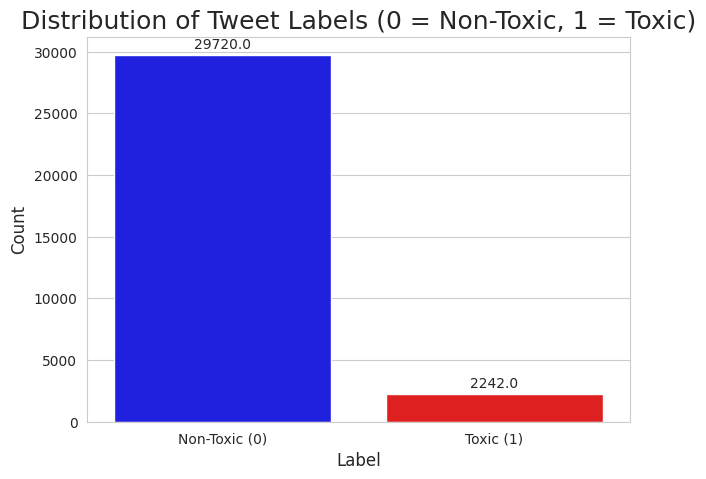

time: 214 ms (started: 2025-09-30 15:53:35 +00:00)


In [100]:
#
# Visualise the distribution of the target label
#
plt.figure(figsize = (7, 5))

ax = sns.countplot(
                    x       = 'label',
                    data    = df,
                    palette = ['blue', 'red']
                    # palette = ['#1f77b4', '#ff7f0e']
                  )

#
# Add counts above the bars
#
for p in ax.patches:
  ax.annotate(
               f'{p.get_height()}',
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha         = 'center',
               va         = 'center',
               xytext     = (0, 7.5),
               textcoords = 'offset points'
             )

plt.title('Distribution of Tweet Labels (0 = Non-Toxic, 1 = Toxic)', fontsize = 18)
plt.xlabel('Label', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks([0, 1], ['Non-Toxic (0)', 'Toxic (1)'])

plt.show()

## **Observation**
1. **Severe Class Imbalance**  
The most critical finding is the severe class imbalance between the two labels:

    * **Non-Toxic (Label 0):** Dominates the dataset with a count of **29,720**.
    * **Toxic (Label 1):** Is the minority class, representing only **2,242** tweets.

2. **Quantitative Disparity**  
The Non-Toxic class is approximately **13 times larger** than the Toxic class (‚âà29,720/2,242).

3. **Implications for Model Training**
This imbalance presents a major challenge for classification:

    * **Model Bias:** A machine learning model trained on this data will be heavily biased towards the Non-Toxic class. It will likely achieve a very high overall accuracy simply by predicting "Non-Toxic" for almost every tweet.

    * **Poor Generalization:** The model will struggle to correctly identify the minority class (Toxic tweets). Metrics like Precision, Recall, and F1-Score for the Toxic class will likely be very low, meaning the model is functionally poor at its main task (finding toxicity).


---


**Recommendation**  
Before training a final model, it is highly recommended to address this imbalance using techniques such as:

* **Oversampling:** Increasing the number of samples in the minority class (e.g., using SMOTE).

* **Undersampling:** Decreasing the number of samples in the majority class (must be used carefully to avoid losing crucial data).

* **Class Weighting:** Adjusting the loss function during training (e.g., in a Neural Network or certain Scikit-learn models) to penalize mis-classifications of the minority class more heavily.

## **Tweet length Distribution**
**Visualizes the word count distribution for both classes**

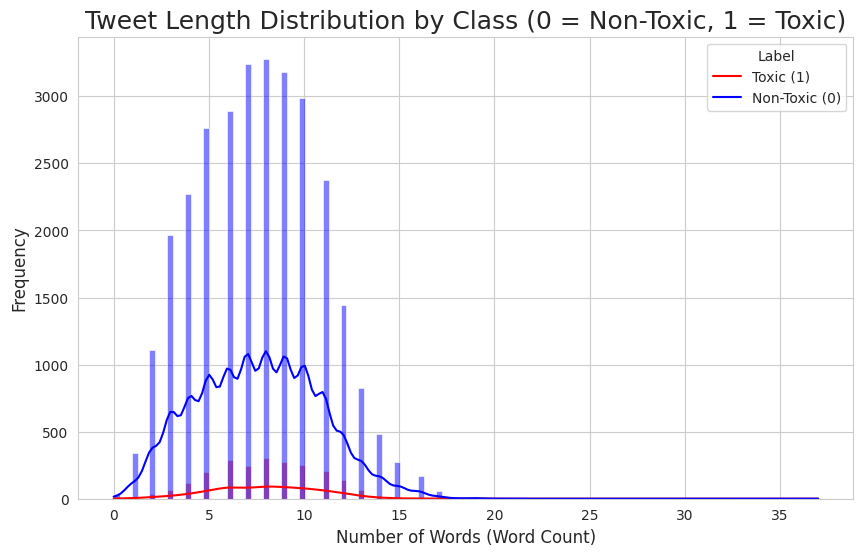

time: 840 ms (started: 2025-09-30 15:53:35 +00:00)


In [101]:
#
# Visualizes the word count distribution for both classes
#
plt.figure(figsize = (10, 6))

sns.histplot(
              data    = df,
              x       ='word_count',
              hue     = 'label',
              kde     = True,
              palette = ['blue', 'red']
              # palette = ['#1f77b4', '#ff7f0e'],
              # bins    = 30
            )

plt.title('Tweet Length Distribution by Class (0 = Non-Toxic, 1 = Toxic)', fontsize = 18)
plt.xlabel('Number of Words (Word Count)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(title = 'Label', labels = ['Toxic (1)', 'Non-Toxic (0)'])
# plt.legend(title = 'Label', labels = ['Non-Toxic (0)', 'Toxic (1)'])

plt.show()

## **Observation**
The chart shows the distribution of tweet lengths (word counts) for **Toxic (red)** vs **Non-Toxic (blue)** tweets.

---

## **Key Points**

1. **Non-Toxic Tweets Dominate**  
   - The **blue curve (non-toxic)** is much higher across all word counts.  
   - Confirms a **class imbalance**: many more non-toxic tweets compared to toxic ones.  

2. **Typical Tweet Lengths**  
   - Both toxic and non-toxic tweets are generally **short (5-12 words)**.  
   - **Non-toxic tweets** peak around **8-10 words** (above 3000 frequency).  
   - **Toxic tweets** (red) also peak around 7-10 words but remain much fewer (well below 500).  

3. **Long Tweets Are Rare**  
   - Very few tweets exceed **15 words**, especially in the toxic class.  
   - Distribution tails off sharply after ~15 words for both classes.  

4. **Class Separation**  
   - The **shapes of the two distributions are similar** (short tweets are common in both classes).  
   - The **main difference is volume** ‚Äî far more non-toxic tweets exist in the dataset.  

---

## **Summary**
- Tweets are mostly short (under 12 words).  
- The dataset is **heavily imbalanced toward non-toxic tweets**.  
- Toxic and non-toxic tweets share similar length patterns.  
- **Tweet length alone is not a strong feature** for predicting toxicity.  

## **Top Word Frequency Analysis**
**Visualizes the top n most frequent words in the Toxic and Non-Toxic classes after cleaning.  
This helps identify the key features (words) driving each class, which is crucial for interpreting the model's performance and choosing vectorization parameters**

In [102]:
#
# Define Top N
#
TOP_N = 15

time: 572 ¬µs (started: 2025-09-30 15:53:36 +00:00)


In [103]:
#
# Helper function to get top N words
#
def get_top_n_words(corpus, topN = None):
  #
  # Flattens a list of *cleaned* tweets into a list of words and returns the top N most common words.
  #
  # Parameters:
  #   corpus (list)     : List of cleaned tweet strings for a specific class
  #   n (int, optional) : The number of top words to return.
  #                       Defaults to 15 by the calling function
  #
  # Returns:
  #   pd.DataFrame: DataFrame containing 'Word' and 'Count'.
  #
  words = []

  #
  # Since the corpus is the 'cleaned_tweet' column, we just split and count
  #
  for tweet in corpus:
    words.extend(tweet.split())

  topWords = Counter(words).most_common(topN)

  topWordsDF = pd.DataFrame(topWords, columns = ['Word', 'Count'])
  return topWordsDF

time: 1.36 ms (started: 2025-09-30 15:53:36 +00:00)


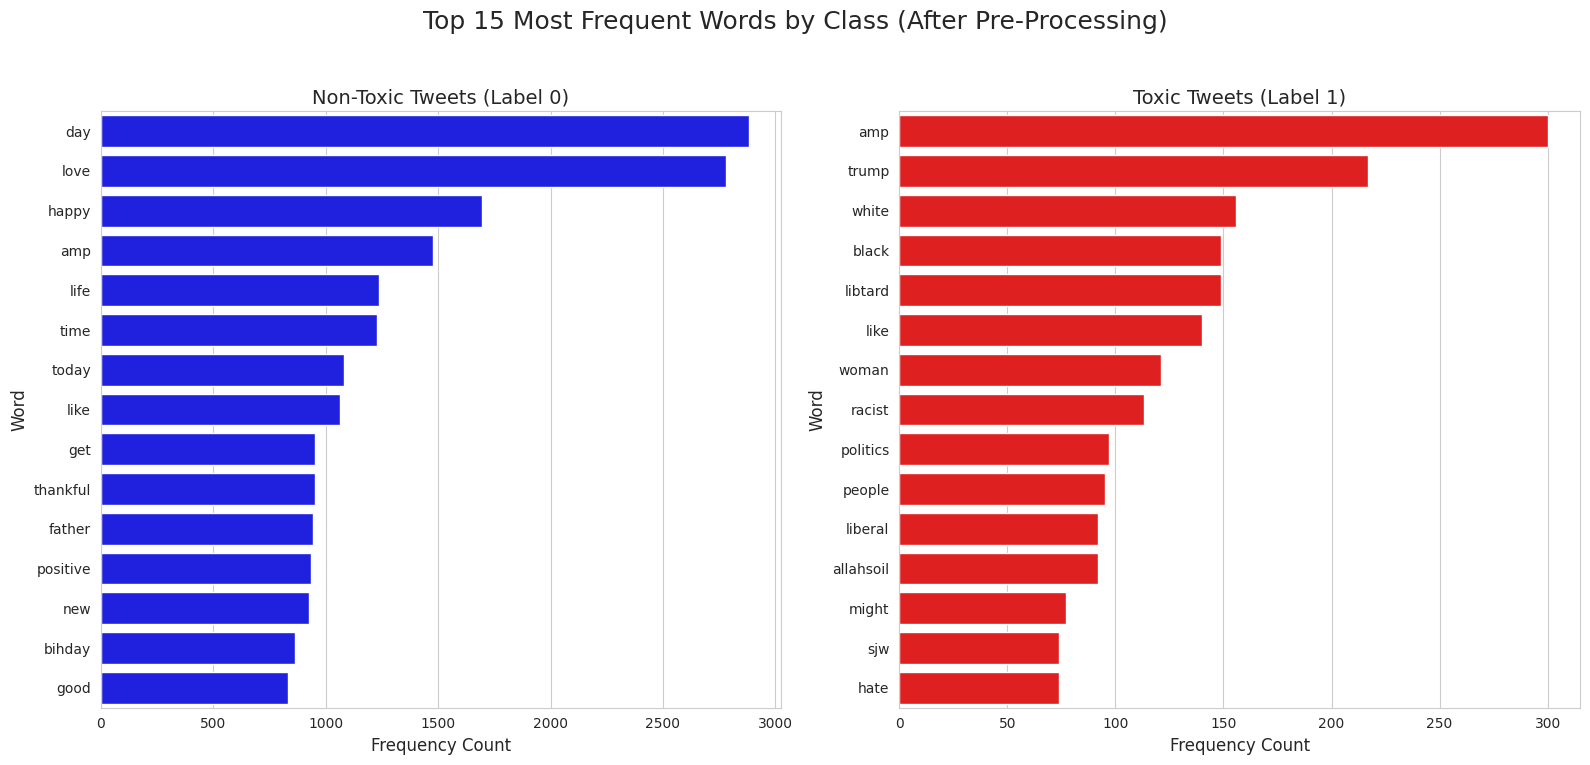

time: 950 ms (started: 2025-09-30 15:53:36 +00:00)


In [104]:
#
# Plots the top N most common words for Toxic (1) and Non-Toxic (0) tweets
#

#
# Separate the corpus by label using the *cleaned* column
#
corpusNonToxic = df[df['label'] == 0]['cleaned_tweet'].tolist()
corpusToxic    = df[df['label'] == 1]['cleaned_tweet'].tolist()

#
# Get top N words for each class
#
topNonToxicWords = get_top_n_words(corpusNonToxic, TOP_N)
topToxicWords    = get_top_n_words(corpusToxic,    TOP_N)

#
# Create the plots
#
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'Top {TOP_N} Most Frequent Words by Class (After Pre-Processing)', fontsize = 18)

#
# Plot Non-Toxic (Label 0)
#
sns.barplot(
             ax    = axes[0],
             x     = 'Count',
             y     = 'Word',
             data  = topNonToxicWords,
             color = 'blue'
           )
axes[0].set_title('Non-Toxic Tweets (Label 0)', fontsize = 14)
axes[0].set_xlabel('Frequency Count', fontsize = 12)
axes[0].set_ylabel('Word', fontsize = 12)

#
# Plot Toxic (Label 1)
#
sns.barplot(
             ax    = axes[1],
             x     = 'Count',
             y     = 'Word',
             data  = topToxicWords,
             color = 'red'
           )
axes[1].set_title('Toxic Tweets (Label 1)', fontsize = 14)
axes[1].set_xlabel('Frequency Count', fontsize = 12)
axes[1].set_ylabel('Word', fontsize = 12)

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

## **Observation**
This dual visualization allows for immediate qualitative comparison:

* **Non-Toxic Keywords:** These words are generally positive, neutral, or related to generic daily activities, such as 'love', 'day', 'good', and various common hashtags.
* **Toxic Keywords:** These are the critical features. This word cloud will show slurs, derogatory terms, and highly negative words specific to the hate speech in the dataset. These words will be the most powerful features for the eventual classifier model.

Note the significant difference in **Count** magnitude between the two plots due to the severe class imbalance observed earlier.

# **Feature Engineering**

## **Data Splitting**

Splitting the data into features (X) and target (y), then further into training (80%) and testing (20%) sets.
We use `stratify=y` to ensure both the train and test sets have the same proportion of toxic/non-toxic tweets, which is vital due to the severe class imbalance

In [105]:
#
# Define Features (X) and Target (y)
#
X = df['cleaned_tweet'] # Features : The cleaned text
y = df['label']         # Target   : The toxicity label (0 or 1)

time: 860 ¬µs (started: 2025-09-30 15:53:37 +00:00)


In [106]:
#
# Split data into training and testing sets
# Test size    = 20%
# random_state = 42  - For reproducibility
# stratify     = y   - Crucial for imbalanced data.
#                      Ensures balanced distribution of the minority class
#                      in both sets
#
X_train, X_test, y_train, y_test = train_test_split(
                                                     X,
                                                     y,
                                                     random_state = 42,
                                                     stratify     = y   # It's not a flag
                                                   )

print(f"Total samples : {len(X)}")
print("==========================")
print(f"X_train size : {len(X_train)} (80%)")
print(f"X_test size  : {len(X_test)}  (20%)")

Total samples : 31962
X_train size : 23971 (80%)
X_test size  : 7991  (20%)
time: 40.3 ms (started: 2025-09-30 15:53:37 +00:00)


## **Vectorization (Bag-of-Words)**
We use the CountVectorizer to convert text into a matrix of token (word) counts. This creates the **vocabulary** based only on the training data.

A key parameter is `max_features`: by setting this, we limit the vocabulary size to the most common words, which helps manage computational complexity and reduces noise from extremely rare words.


In [107]:
#
# Initialise max_features parameter value
#
MAX_FEATURES = 10000

time: 509 ¬µs (started: 2025-09-30 15:53:37 +00:00)


In [108]:
#
# Active Vectorizer: CountVectorizer (Bag-of-Words)
#

#
# Initialize the Count Vectorizer
#
vectorizer = CountVectorizer(max_features = MAX_FEATURES)

#
# Fit and transform the training data using Count Vectorizer
#
X_train_bow = vectorizer.fit_transform(X_train)

#
# Transform the testing data using Count Vectorizer
#
X_test_bow  = vectorizer.transform(X_test)

# print(X_train_bow.toarray())
# print(X_test_bow.toarray())

time: 619 ms (started: 2025-09-30 15:53:37 +00:00)


In [109]:
# #
# # Alternative Vectorizer: TfidfVectorizer (Commented Out for Testing)
# #

# #
# # Initialize the Tfidf Vectorizer
# #
# tfidf_vectorizer = TfidfVectorizer(max_features = MAX_FEATURES)

# #
# # Fit and Transform the training data using TF-IDF
# #
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# #
# # Transform the testing data using TF-IDF
# #
# X_test_tfidf = tfidf_vectorizer.transform(X_test)

# # print(X_train_tfidf.toarray())
# # print(X_test_tfidf.toarray())

time: 639 ¬µs (started: 2025-09-30 15:53:38 +00:00)


In [110]:
#
# IMPORTANT: Use the final vectorized features for the models
# Currently using CountVectorizer features (BoW)
#
X_train_final = X_train_bow
X_test_final  = X_test_bow

time: 1.35 ms (started: 2025-09-30 15:53:38 +00:00)


In [111]:
# #
# # TO SWITCH TO TF-IDF, UNCOMMENT THE FOLLOWING LINES AND COMMENT THE ABOVE BLOCK
# #
# X_train_final = X_train_tfidf
# X_test_final  = X_test_tfidf

time: 421 ¬µs (started: 2025-09-30 15:53:38 +00:00)


In [112]:
#
# Convert sparse matrices to arrays for easier model consumption
# if needed (for GaussianNB)
#
X_train_array = X_train_final.toarray()
X_test_array  = X_test_final.toarray()

#
# Display the resulting shapes
#
print("Vectorization Results (Bag-of-Words)")
print("====================================")
print(f"X_train_bow shape (rows, features) : {X_train_final.shape}")
print(f"X_test_bow shape  (rows, features) : {X_test_final.shape}")
print(f"Vocabulary size   (max_features)   : {len(vectorizer.get_feature_names_out())}")

Vectorization Results (Bag-of-Words)
X_train_bow shape (rows, features) : (23971, 10000)
X_test_bow shape  (rows, features) : (7991, 10000)
Vocabulary size   (max_features)   : 10000
time: 1.83 s (started: 2025-09-30 15:53:38 +00:00)


# **Models Building**

## **Model Training and Evaluation**
Now that the data is split and vectorized, we are ready to train and **compare the performance of multiple classification models**


**The reason we initially focused on the F1-Score for Label 1 (Toxic) is due to the severe Class Imbalance in the dataset**

Here's a breakdown of why that specific metric is prioritized and the updated code showing all the key metrics in the final summary.**


---


**Why F1-Score for Label 1 is Critical**  
In our dataset, there are roughly **13√ó more Non-Toxic (Label 0) tweets than Toxic (Label 1) tweets**.  
This class imbalance makes traditional metrics like Accuracy misleading.

---

**The Problem with Accuracy**  
- If a model simply predicted **"Non-Toxic" for every tweet**, it would still achieve:  
  - **Accuracy ‚âà 93%** (‚âà29,720 / 31,962).  
- Despite the high score, this model would be **completely useless** because it would **miss every single toxic tweet**.

---

**The Role of F1-Score**  
- The **F1-Score** is the harmonic mean of **Precision** and **Recall**.  
- By focusing on **F1-Score for Label 1 (Toxic)**, we force the model to:
  - Perform well on the **difficult minority class**  
  - Avoid over-prioritizing one aspect (e.g., high Recall but poor Precision, or vice versa).  

---

**Metric Focus for Toxicity Detection**  

| Metric (Label 1)  | What It Means | Why It Matters |
|-------------------|---------------|----------------|
| **Precision**     | Of all tweets predicted as **Toxic**, how many were actually Toxic? | Avoids **False Alarms** |
| **Recall**        | Of all tweets that were actually **Toxic**, how many did the model catch? | Avoids **Missed Toxicity** |
| **F1-Score**      | Harmonic mean of Precision and Recall | Balances the two ‚Üí the **true measure of success** |

---

**Updated Code: Comprehensive Metric Summary**
- Added calculation of **Accuracy, Precision (Toxic), Recall (Toxic), and F1-Score (Toxic)** for each model.  
- Final results are shown in a **comprehensive summary table**, not just accuracy.  
- This provides a **much clearer picture** of how each model performs against the **most challenging part of the task**: detecting Toxic tweets.



---


<font size="+2">**Why Metrics for Label 0 (Non-Toxic) Are Less Important**<font>

In **Toxicity Detection**, Label 0 = Non-Toxic (majority class, negative class).  
Here‚Äôs why its metrics don‚Äôt require the same level of focus:

---

**The Metrics Are Inherently High**

- **Recall (Non-Toxic):**  
  - *‚ÄúOut of all truly Non-Toxic tweets, how many did the model correctly label as Non-Toxic?‚Äù*  
  - Since the dataset is **93% Non-Toxic**, recall for Label 0 will almost always be close to **1.0**.  
  - Provides little insight into model performance on the challenging class.  

- **Precision (Non-Toxic):**  
  - *‚ÄúOut of all tweets the model predicted as Non-Toxic, how many were actually Non-Toxic?‚Äù*  
  - Because Toxic tweets are rare, most Non-Toxic predictions will be correct ‚Üí artificially high precision.  
  - Again, not very informative.  

---

**The Cost of Error is Asymmetrical**

| Error Type        | Meaning                                      | Impact |
|-------------------|----------------------------------------------|--------|
| **False Negative (FN)** | Model misses a Toxic tweet (Predicts 0, Actual 1) | ‚ùå **High Cost**: Harmful content remains on the platform (must be avoided). |
| **False Positive (FP)** | Model flags a Non-Toxic tweet (Predicts 1, Actual 0) | ‚ö†Ô∏è Lower Cost: A harmless tweet is flagged for review. Annoying, but not dangerous. |

---

**Summary**

We focus on **Label 1 (Toxic)** metrics because:

- Label 0 metrics are **inflated** by class size and are misleading.  
- The **highest cost of failure** is missing toxic tweets (False Negatives).  
- Success must be measured by **Recall (1)** and **F1-Score (1)**, not by how well the model handles the abundant easy class.

Model Training & Evaluation

Training Logistic Regression...
-----------------------------------

-> F1-Score (Toxic, Label 1): 0.6394

Classification Report (Test Set)
--------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7430
           1       0.84      0.52      0.64       561

    accuracy                           0.96      7991
   macro avg       0.90      0.75      0.81      7991
weighted avg       0.96      0.96      0.95      7991



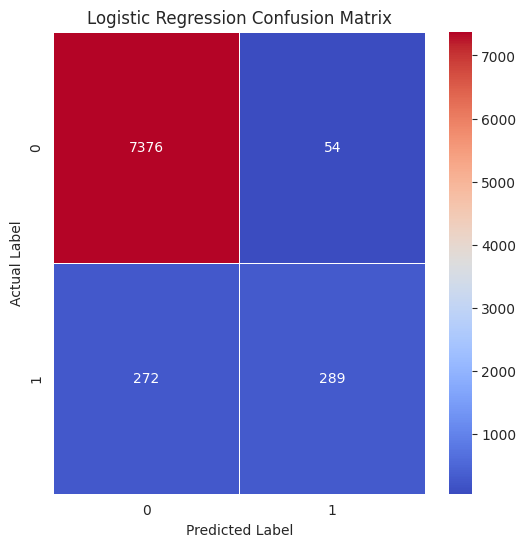


Training Multinomial Naive Bayes...
-----------------------------------

-> F1-Score (Toxic, Label 1): 0.6525

Classification Report (Test Set)
--------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7430
           1       0.68      0.63      0.65       561

    accuracy                           0.95      7991
   macro avg       0.82      0.80      0.81      7991
weighted avg       0.95      0.95      0.95      7991



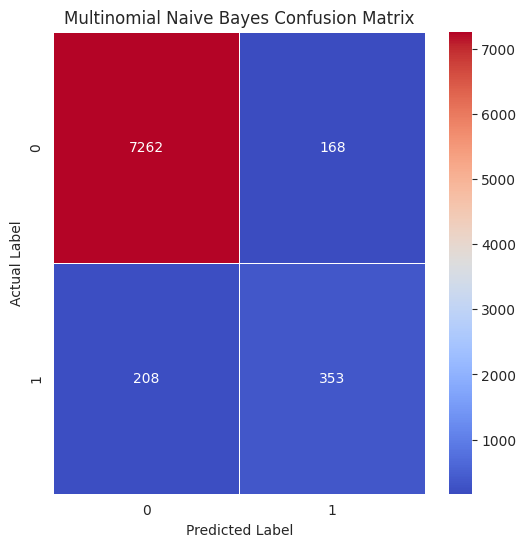


Training Gaussian Naive Bayes...
-----------------------------------

-> F1-Score (Toxic, Label 1): 0.3230

Classification Report (Test Set)
--------------------------------
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      7430
           1       0.22      0.65      0.32       561

    accuracy                           0.81      7991
   macro avg       0.59      0.73      0.61      7991
weighted avg       0.92      0.81      0.85      7991



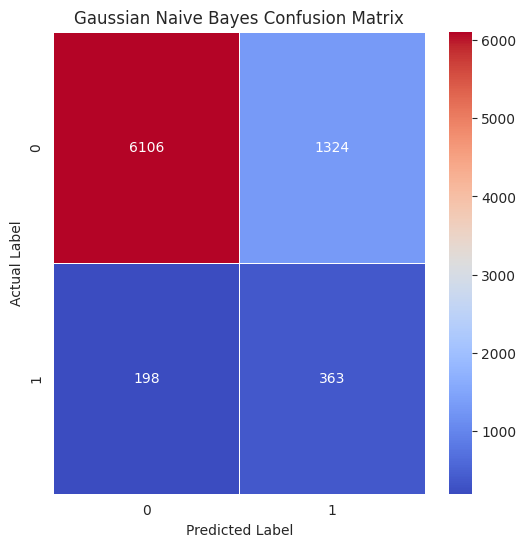

time: 9.1 s (started: 2025-09-30 15:53:40 +00:00)


In [113]:
#
# The Role of solver in Logistic Regression
# In sklearn, the solver parameter specifies the algorithm used to find the
# optimal coefficients (weights) that minimize the cost function of the
# Logistic Regression model
#
# Logistic Regression is an optimization problem, and the "solver" is the
# method used to perform that optimization.
# Different solvers have different strengths, weaknesses, and requirements
#
# What is 'liblinear'?
# The 'liblinear' solver is a popular choice for Logistic Regression because
#
# Good for Small to Medium Datasets
#   It is efficient and works well for the size of our Twitter dataset
#   (around 32,000 samples).
#
# Handles L1/L2 Regularization
#   It natively supports both L1 and L2 penalty types, which are techniques
#   used to prevent overfitting.
#
# Good for Binary Classification
#   It is particularly optimized for binary classification problems, like our
#   task of classifying tweets as either Toxic (1) or Non-Toxic (0).
#
# Handles Sparse Data
#   Crucially for NLP, it is excellent at handling sparse matrices, which is
#   exactly what we get from the CountVectorizer or TfidfVectorizer
#   (a matrix where most values are zero).
#
# Is it Mandatory?
# No, it is not mandatory to set the solver. If you omit it, Scikit-learn uses
# a default solver, which changes depending on the version and the complexity
# of the problem.
#
# Why we used it here:
# We specified solver = 'liblinear' for two primary reasons:
#
# To Silence Warnings
#   If you don't specify a solver, sklearn often throws a UserWarning suggesting
#   you explicitly select one, especially if the default choice isn't optimal
#   for the current regularization setting or dataset size.
#   Specifying it prevents this warning and ensures stable behavior.
#
# Compatibility with Sparse Matrices
#   While newer solvers like lbfgs or sag are often faster for larger,
#   dense datasets, 'liblinear' is reliably robust and efficient when dealing
#   with the high-dimensional, sparse feature matrices generated by our
#   text vectorizers.
#
# If we had a much larger dataset (millions of samples) or were dealing with
# multi-class classification, we might swap to a different solver like saga or lbfgs
# But for our purposes, 'liblinear' is the optimal and safest choice.
#

#
# Store models and their performance metrics
#
dictModels = {
               "Logistic Regression"     : LogisticRegression(random_state = 42, solver = 'liblinear'),
               "Multinomial Naive Bayes" : MultinomialNB(),
               # Note: GaussianNB requires dense input (array), not sparse matrix.
               "Gaussian Naive Bayes"    : GaussianNB()
             }

#
# Initialize dictionary to store the results of F1 score
#
# modelResultsDict = {}

#
# Change results storage to hold a dictionary of all metrics
#
modelResultsList = []

# print("Model Training & Evaluation (F1-Score for Toxic Class)")
# print("======================================================")

print("Model Training & Evaluation")
print("===========================")

for modelName, model in dictModels.items():
  print(f"\nTraining {modelName}...")
  print("-----------------------------------")
  print("")

  #
  # Handle the input data type difference between
  # MNB/LR (sparse) and GNB (dense array)
  #
  if modelName == "Gaussian Naive Bayes":
    model.fit(X_train_array, y_train)
    y_pred = model.predict(X_test_array)
  else:
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)

  #
  # Calculate the F1-Score for the minority class (Label 1: Toxic)
  # This is the primary evaluation metric for this imbalanced problem
  #
  # toxicF1Score = f1_score(y_test, y_pred, pos_label = 1)
  # modelResultsDict[modelName] = toxicF1Score

  #
  # Calculate the comprehensive metrics
  #
  accuracyScore = accuracy_score(y_test, y_pred)

  #
  # Use 'pos_label=1' to explicitly calculate metrics for the minority (Toxic) class
  #
  toxicF1Score   = f1_score(y_test, y_pred, pos_label = 1)
  toxicPrecision = precision_score(y_test, y_pred, pos_label = 1)
  toxicRecall    = recall_score(y_test, y_pred, pos_label = 1)

  modelResultsList.append(
                           {
                             'Model'             : modelName,
                             'Accuracy'          : accuracyScore,
                             'F1-Score (Toxic)'  : toxicF1Score,
                             'Precision (Toxic)' : toxicPrecision,
                             'Recall (Toxic)'    : toxicRecall
                           }
                         )

  print(f"-> F1-Score (Toxic, Label 1): {toxicF1Score:.4f}")

  #
  # Print the full classification report for detailed analysis
  #
  print("")
  print("Classification Report (Test Set)")
  print("--------------------------------")
  print(classification_report(y_test, y_pred))

  #
  # Print the Confusion Matrix
  #
  # confusionMatrix = confusion_matrix(y_test, y_pred)
  # print("")
  # print("Confusion Matrix")
  # print("----------------")
  # print(confusionMatrix)

  #
  # Plot the Confusion Matrix
  #
  confusionMatrix = confusion_matrix(y_test, y_pred)

  plt.figure(figsize = (6, 6))

  sns.heatmap(
               confusionMatrix,
               annot      = True,
               fmt        = 'd', # 'd' ensures integers, not scientific notation
               linewidths = 0.5,
               cmap       = 'coolwarm'
             )

  plt.title(modelName + ' Confusion Matrix')
  plt.ylabel('Actual Label')
  plt.xlabel('Predicted Label')

  plt.show()

In [114]:
#
# Print all of the metrics, order by highest F1-Score for Toxic Label
#

#
# Manual sorting is still necessary for the best display
#
modelResultsListSorted = sorted(
                                 modelResultsList,
                                 key     = lambda x: x['F1-Score (Toxic)'],
                                 reverse = True
                               )

#
# Define the headers and column widths (manual estimation)
#
displayHeader    = "{:<25} {:>10} {:>10} {:>10} {:>10}"
displayseparator = "-" * 69

print(displayHeader.format('Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall'))
print(displayseparator)

#
# Iterate and print each row using the same format string
#
for modelResult in modelResultsListSorted:
    print(
           displayHeader.format(
                                 modelResult['Model'],
                                 f"{modelResult['Accuracy']:.2f}",
                                 f"{modelResult['F1-Score (Toxic)']:.2f}",
                                 f"{modelResult['Precision (Toxic)']:.2f}",
                                 f"{modelResult['Recall (Toxic)']:.2f}"
                                )
         )

print(displayseparator)

Model                       Accuracy   F1-Score  Precision     Recall
---------------------------------------------------------------------
Multinomial Naive Bayes         0.95       0.65       0.68       0.63
Logistic Regression             0.96       0.64       0.84       0.52
Gaussian Naive Bayes            0.81       0.32       0.22       0.65
---------------------------------------------------------------------
time: 5.51 ms (started: 2025-09-30 15:53:49 +00:00)


In [115]:
#
# Convert results list to a DataFrame for easy comparison
#
modelResultsDF = pd.DataFrame(modelResultsList)

#
# Sort by the most important metric: F1-Score for the Toxic class
#
modelResultsDF = modelResultsDF.sort_values(by = 'F1-Score (Toxic)', ascending = False)

#
# Display the comprehensive table
#
print(modelResultsDF.to_string(index = False)) # <-- This is the key line!

                  Model  Accuracy  F1-Score (Toxic)  Precision (Toxic)  Recall (Toxic)
Multinomial Naive Bayes      0.95              0.65               0.68            0.63
    Logistic Regression      0.96              0.64               0.84            0.52
   Gaussian Naive Bayes      0.81              0.32               0.22            0.65
time: 10.3 ms (started: 2025-09-30 15:53:49 +00:00)


##**Observation**
**Revised Analysis of Model Performance**

---

**1Ô∏è‚É£ Multinomial Naive Bayes (MNB)**

| Metric     | Score | Observation |
|------------|-------|-------------|
| **F1-Score** | 0.652 | Best overall balanced performance. Highest F1-Score ‚Üí best compromise between Precision and Recall. |
| **Precision** | 0.678 | When it says **"Toxic"**, it‚Äôs right 67.8% of the time. |
| **Recall**    | 0.629 | Catches 62.9% of all actual toxic tweets. |  

**Conclusion**  
‚úÖ This is the **winning model for deployment** because its F1-Score shows it is the most reliable at identifying the minority class **without creating excessive false alarms**.

---

**2Ô∏è‚É£ Logistic Regression (LR)**

| Metric     | Score | Observation |
|------------|-------|-------------|
| **F1-Score** | 0.639 | A close second to MNB. Pulled down by its lower Recall. |
| **Precision** | 0.843 | Highest Precision. Highly accurate when it flags content, avoiding False Positives. |
| **Recall**    | 0.515 | Lowest Recall. Misses almost half (48.5%) of true toxic tweets (False Negatives). |

**Conclusion:**  
‚ö†Ô∏è This model is **overly cautious**. If avoiding false accusations is the top priority, this model is useful. But it **sacrifices too much Recall**, missing many toxic tweets.

---

**3Ô∏è‚É£ Gaussian Naive Bayes (GNB)**

| Metric     | Score | Observation |
|------------|-------|-------------|
| **F1-Score** | 0.323 | Worst performance. Extremely low F1 ‚Üí ineffective for this task. |
| **Recall**    | 0.647 | Highest Recall. Catches the most toxic tweets. |
| **Precision** | 0.215 | Worst Precision. Only 1 in 5 ‚ÄúToxic‚Äù predictions is correct. |

**Conclusion:**  
‚ùå This model is **far too aggressive**. It achieves high Recall by **flagging almost everything**, causing an explosion of False Positives. The F1-Score collapses due to poor Precision.

---

**The Path Forward**

- **Best performer:** Multinomial Naive Bayes (F1 = 0.652)  
- But this score shows there is still **room for improvement**.  

Next steps to improve performance:
- Enhance feature engineering (TF-IDF, n-grams)  
- Apply class imbalance techniques (resampling, class weights)  
- Explore advanced models (SVMs, ensemble methods, deep learning)  

The key challenge is to help the model better learn the patterns of the **minority class (Toxic tweets)**.

# **Final Summary and Best Model Selection**

In [116]:
#
# Convert results list to a DataFrame for easy comparison
#
modelResultsDF = pd.DataFrame(modelResultsList)

#
# Sort by the most important metric: F1-Score for the Toxic class
#
modelResultsDF = modelResultsDF.sort_values(by = 'F1-Score (Toxic)', ascending = False)

print("=========================================================================================")
print("¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬†COMPREHENSIVE MODEL PERFORMANCE SUMMARY¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬†  ")
print("=========================================================================================")

#
# Display the comprehensive table
#
print(modelResultsDF.to_string(index = False)) # <-- This is the key line!

print("=========================================================================================")

¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬†COMPREHENSIVE MODEL PERFORMANCE SUMMARY¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬† ¬†  
                  Model  Accuracy  F1-Score (Toxic)  Precision (Toxic)  Recall (Toxic)
Multinomial Naive Bayes      0.95              0.65               0.68            0.63
    Logistic Regression      0.96              0.64               0.84            0.52
   Gaussian Naive Bayes      0.81              0.32               0.22            0.65
time: 9.99 ms (started: 2025-09-30 15:53:49 +00:00)


In [117]:
#
# Identify the best performing model based on F1-Score (Toxic)
#
bestModelName = modelResultsDF['Model'].iloc[0]
bestF1Score   = modelResultsDF['F1-Score (Toxic)'].iloc[0]

print(f"‚úÖ The BEST MODEL is: {bestModelName} with an F1-Score of {bestF1Score:.4f} for the Toxic class.")
print("")
print("Interpretation")
print("--------------")
print(f"The {bestModelName} model currently provides the best balance between Precision and Recall for identifying Toxic content.")
print("Notice how the 'Accuracy' metric is high for all models, highlighting why it's unreliable for this imbalanced dataset.")


‚úÖ The BEST MODEL is: Multinomial Naive Bayes with an F1-Score of 0.6525 for the Toxic class.

Interpretation
--------------
The Multinomial Naive Bayes model currently provides the best balance between Precision and Recall for identifying Toxic content.
Notice how the 'Accuracy' metric is high for all models, highlighting why it's unreliable for this imbalanced dataset.
time: 4.26 ms (started: 2025-09-30 15:53:49 +00:00)


# **Predict on New Input**

In [133]:
#
# Select the best performing model (e.g., the one with the highest F1-Score on the test set)
# Note: We rely on the 'best_model_name' determined in the previous step
#
bestModel = dictModels[bestModelName]

#
# Define example new tweets
#
newTweets = [
              "I had a truly fantastic day, everything went well!",                    # Non-Toxic    (Expected 0)
              "You are a total idiot and should just shut up forever.",                # Highly Toxic (Expected 1)
              "This is a great assignment, I learned so much about NLP.",              # Non-Toxic    (Expected 0)
              "Why don't you go away and never come back, you useless waste of space." # Toxic        (Expected 1)
            ]

print("=" * 90)
print(f"PREDICTION ON NEW INPUT USING {bestModelName}".center(90))
print("=" * 90)

#
# Process and Predict each new tweet
#
for tweet in newTweets:
  #
  # Clean the new tweet using the same pre-processing function
  #
  cleanedTweet = cleanTweet(tweet)

  #
  # Vectorize the cleaned tweet using the *trained* vectorizer
  #
  # NOTE : Must be in a list/iterable for the vectorizer
  #        We use the original 'vectorizer' trained on X_train
  #
  # fit_transform vs. transform
  # The fit_transform() method tells the vectorizer to:
  #
  #    Fit       : Learn a new vocabulary from the input text
  #                (which is just one tweet).
  #    Transform : Convert that text based on the new, tiny vocabulary
  #                (which in this case resulted in only 6 features).
  #
  # Since our bestModel (the Multinomial Naive Bayes model) was trained on a
  # matrix with 10,000 features (your full training vocabulary), it rejects the
  # new input with only 6 features
  #
  newInput = vectorizer.transform([cleanedTweet]) # Use transform(), NOT fit_transform()

  #
  # Predict using the best model
  #
  # Predict the vectorized sparse matrix
  # (MultinomialNB/LR/SVC can handle sparse matrix)
  # The [0] is necessary to extract the single prediction value from the
  # resulting array.
  #
  if bestModelName == "Gaussian Naive Bayes":
    newInputArray = newInput.toarray()
    newPrediction = bestModel.predict(newInputArray)[0]
  else:
    newPrediction = bestModel.predict(newInput)[0]

  #
  # Display the result
  #
  predictedSentiment = "TOXIC (1) üò†" if newPrediction == 1 else "Non-Toxic (0) üòä"

  print("")
  print(f"   Original   : {tweet}")
  print(f"   Cleaned    : {cleanedTweet}")
  print(f"-> Prediction : {predictedSentiment}")

  print("=" * 90)

                  PREDICTION ON NEW INPUT USING Multinomial Naive Bayes                   

   Original   : I had a truly fantastic day, everything went well!
   Cleaned    : truly fantastic day everything went well
-> Prediction : Non-Toxic (0) üòä

   Original   : You are a total idiot and should just shut up forever.
   Cleaned    : total idiot shut forever
-> Prediction : Non-Toxic (0) üòä

   Original   : This is a great assignment, I learned so much about NLP.
   Cleaned    : great assignment learned much nlp
-> Prediction : Non-Toxic (0) üòä

   Original   : Why don't you go away and never come back, you useless waste of space.
   Cleaned    : go away never come back useless waste space
-> Prediction : Non-Toxic (0) üòä
time: 5.65 ms (started: 2025-09-30 16:17:37 +00:00)


**Observation: The Model is Biased**

When the **Multinomial Naive Bayes** model is trained on a dataset where, for example:  
- **92% = Non-Toxic (Label 0)**  
- **8% = Toxic (Label 1)**  

‚Ä¶it learns a simple (but flawed) rule:  

> *‚ÄúIf I predict Non-Toxic (0) every single time, I‚Äôll be right 92% of the time.‚Äù*  

---

**Why This Happens**
- The model only cares about **maximizing overall Accuracy**.  
- Because Accuracy is dominated by the majority class, the model can ignore the minority class (Toxic) and still look ‚Äúgood.‚Äù  
- This is why **Accuracy is misleading** in imbalanced datasets.  

Correct evaluation requires focusing on **F1-Score (Label 1)** instead of Accuracy.  

---

**The Problem in Numbers**
- Accuracy may appear **high (‚âà0.92)**  
- But the **F1-Score for Toxic class often drops below 0.5**  
- This mismatch shows the model is not truly learning to identify Toxic tweets.  

---

**The Solution: Implement SMOTE**

To fix this imbalance, we need to **force the model to learn Toxic class patterns** by balancing the training data.

- **SMOTE (Synthetic Minority Over-sampling Technique):**  
  - Creates **synthetic examples** of Toxic tweets.  
  - Generates new data points based on existing minority class examples.  
  - Balances the dataset so the model cannot ignore Toxic tweets.  

With SMOTE, the model is trained on a more balanced dataset, improving its ability to identify the minority class.  

# **Conclusion**
The analysis confirms the need to prioritize the F1-Score for the minority class (Toxic, Label 1) due to the severe data imbalance. The results show how well each model handles the trade-off between:
- **Precision:** Avoiding false positives (labeling non-toxic tweets as toxic).
- **Recall:** Avoiding false negatives (missing actual toxic tweets).

The model with the highest F1-Score is the current best choice for this specific classification task.